# Human Pose Estimation(HPE)

* 첫 번째 방법은 Top-down 방법입니다.**(여기서 다루는 내용)**

    모든 사람의 정확한 keypoint 를 찾기 위해 object detection 을 사용합니다.
    crop 한 이미지 내에서 keypoint 를 찾아내는 방법으로 표현합니다.
    detector가 선행되어야 하고 모든 사람마다 알고리즘을 적용해야 하기 때문에 사람이 많이 등장할 때는 느리다는 단점이 있습니다.  


* 두 번째 방법은 Bottom-up 방법입니다.

    detector가 없고 keypoint 를 먼저 검출합니다.
    예를 들어 손목에 해당하는 모든 점들을 검출합니다.
    한 사람에 해당하는 keypoint 를 clustering 합니다.
    detector 가 없기 때문에 다수의 사람이 영상에 등장하더라도 속도 저하가 크지 않습니다. 반면 top down 방식에 비해 keypoint 검출 범위가 넓어 성능이 떨어진다는 단점이 있습니다.

 Pose 는 face landmark 랑 비슷해요. human pose estimation 은 keypoint 의 localization 문제를 푼다는 점에서 비슷합니다. 하지만 손목, 팔꿈치 등의 joint keypoint 정보는 얼굴의 keypoint 보다 훨씬 다양한 위치와 변화를 보입니다.

위 이미지에서 볼 수 있듯이 손이 얼굴을 가리는 행위, 모든 keypoint 가 영상에 담기지 않는 등 invisible , occlusions, clothing, lighting change 가 face landmark 에 비해 더 어려운 환경을 만들어 냅니다.

딥러닝 기반 방법이 적용되기 전에는 다양한 사전 지식이 사용되었습니다.
가장 기본이 되는 아이디어는 "인체는 변형 가능 부분으로 나누어져 있고 각 부분끼리 연결성을 가지고 있다." 는 것입니다.

#### 데이터 전처리하기

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

BEST_MODEL_PATH = os.path.join(PROJECT_PATH, 'best_models') # 수정
SEEIFBETTER_MODEL_PATH = os.path.join(PROJECT_PATH, 'seeifbetter_models') # 수정


print('슝=3')

슝=3


* **json 파싱하기**  

이전 스텝에서 train.json과 validation.json 파일이 소개된 것을 기억하시나요? 이 파일들은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있어서 Pose Estimation을 위한 label로 삼을 수 있습니다.

우선 json이 어떻게 구성되어 있는지 파악해 보기 위해 json 파일을 열어 샘플로 annotation 정보를 1개만 출력해 봅시다. json.dumps()를 활용해서 좀 더 명확하게 하면 더욱 좋습니다.

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json) # json파일객체을 열어서
    json_formatted_str = json.dumps(train_annos[0], indent=2) # 해당부분을 문자열로 변환
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


joints 가 우리가 label 로 사용할 keypoint 의 label 입니다. 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에 joints_vis 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냅니다. MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용할 수 있습니다. coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있습니다.

joints 순서는 아래와 같은 순서로 배치되어 저장해 뒀습니다.

>0 - 오른쪽 발목  
1 - 오른쪽 무릎  
2 - 오른쪽 엉덩이    
3 - 왼쪽 엉덩이  
4 - 왼쪽 무릎  
5 - 왼쪽 발목  
6 - 골반  
7 - 가슴(흉부)  
8 - 목  
9 - 머리 위  
10 - 오른쪽 손목  
11 - 오른쪽 팔꿈치  
12 - 오른쪽 어깨  
13 - 왼쪽 어깨  
14 - 왼쪽 팔꿈치  
15 - 왼쪽 손목  

scale과 center는 사람 몸의 크기와 중심점 입니다.scale은 200을 곱해야 온전한 크기가 됩니다. 추후에 전처리 과정에서 200을 곱해서 사용할 예정이에요.

이제 json annotation 을 파싱하는 함수를 만들어 보겠습니다.

> MPII 데이터셋에서 'scale'은 사람의 크기 비율을 나타내는데, 관절의 위치 및 사람의 신체 부분 크기를 상대적으로 표현하는 데 사용됩니다.
일반적으로 관절의 좌표는 이미지의 크기에 따라 상대적으로 바뀌는 값이기 때문에 이를 보정하기 위해 scale 값을 제공하는 것이며, 이를 통해서 다른 크기의 이미지에서도 신체 부위의 위치를 일관성 있게 분석할 수 있습니다.

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


한 번 parse_one_annotation()함수를 테스트 해봅시다.

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json) # json파일객체을 열어서
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


### TFRecord 파일 만들기

이전까지는 tf.keras 의 ImageDataGenerator 를 이용해서 주로 학습 데이터를 읽었습니다. 하지만 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다뤄야 합니다.

학습을 많이 해볼수록 학습 속도에 관심을 가지게 되는데요. tensorflow 튜토리얼 문서에는 다음과 같은 표현으로 나타나 있습니다.

unless you are using tf.data and reading data is still the bottleneck to training.

일반적으로 학습 과정에서 gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생하고 대단위 프로젝트 실험에서 효율성이 떨어지는 것을 관찰할 수 있습니다. (답답해요..)

따라서 "학습 데이터를 어떻게 빠르게 읽는가?" 에 대한 고민을 반드시 수행하셔야 더 많은 실험을 할 수 있습니다.

* 학습 속도를 향상시키기 위해서 데이터 관점에서 고려해야하는 단계는 어떤 단계인가요? 속도 향상을 위한 처리 방법을 위 링크에서 찾아대답해 봅시다.

> data read(또는 prefetch) 또는 데이터 변환 단계. gpu 학습과 병렬적으로 수행되도록 prefetch를 적용해야 함. 수행방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법을 사용해야함.

내용이 꽤 어렵습니다만 tf 에서는 위 변환을 자동화해주는 도구를 제공합니다. 데이터셋을 TFRecord 형태로 표현하는 것인데요. TFRecord 는 binary record sequence 를 저장하기 위한 형식입니다.

내부적으로 protocol buffer 라는 것을 이용합니다.

protocol buffer 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하시면 됩니다.

데이터를 직렬화 한다는 것은 의미가 있는 정보만 추출해 나열하는 것을 뜻합니다. 예를 들어 "서울 강동구에 사는 32살 고길동"님을 나타내기 위해 "서울강동32고길동"과 같이 쓴다면 데이터만 담을 수 있겠죠? 다만 데이터 형식을 고정해야 하기 때문에 첫 두 글자는 시를 뜻하고, 다음 두 글자는 구를 뜻하고 다음 두 자리 숫자가 오고 이름은 세 글자여야 하는 제한이 생깁니다. 100살이 넘는 사람이나 이름이 세 글자가 아닌 사람을 담을 수 없어요. 그래서 매우 정형화된 데이터는 직렬화 하면 데이터 크기와 처리 속도 측면에서 유리하지만 사용하는데 제한이 있다고 기억하면 좋습니다. 어떤 데이터에서 어떤 방법으로 직렬화를 수행할지에 따라 발생되는 제한이 달라질 수도 있고요.

이제 구현을 시작하겠습니다. 하나하나 천천히 가보죠. **앞서 추출한 annotation을 TFRecord로 변환하는 함수를 만들게요. TFRecord 는 tf.train.Example들의 합으로 이루어지므로 하나의 annotation을 하나의 tf.train.Example로 만들어 주는 함수부터 작성합니다.**

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


하나의 annotation이 tf.train.Example이 되었다면 이제 여러 annotation에 대해 작업할 수 있도록 함수를 만들어야 합니다.

그런데 **여기서 하나의 TFRecord를 만들지 않고 여러 TFRecord를 만들어 볼 거예요. 우선 얼마나 많은 TFRecord를 만들지 결정할 함수를 만들게요.**

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


이 함수는 전체 데이터를 몇 개의 그룹으로 나눌지 결정해 줍니다. 전체 데이터 l을 n그룹으로 나눕니다. 결과적으로 n개의 TFRecord 파일을 만들겠다는 이야기입니다.

여기서 좀 더 전문적으로는 n개로 shard 했다고 말합니다. 기업 단위의 데이터는 매우 크고 여러 장비에 나누어져 있기 때문에 sharding은 자주 이루어 집니다. 하나의 큰 데이터를 여러 개의 파일로 쪼개고 여러 컴퓨터에 나누어 담는 것이라고 여기면 됩니다. 이렇게 하면 데이터 저장에도 용이하고 병렬 처리에 하는데 이점이 있습니다.

이 때, 이 데이터는 원래 하나의 큰 데이터였기 때문에 저장 후 어떻게 사용할 것인가에 따라서 sharding 전략이 달라지는데요. 그 내용을 다루기에는 너무 방대하니 여기서는 간단히만 다룹니다. 모델을 학습하는데 각 파일의 크기와 개수만 고려해보면, 너무 작은 파일로 많이 나누는 것도, 너무 큰 파일로 적게 나누는 것도 좋지 않습니다. 너무 작은 파일로 많이 나누면 학습 중간에 너무 잦은 입출력이 요구되고, 너무 큰 파일로 적게 나누면 입출력마다 걸리는 시간이 길어집니다. 입출력에 걸리는 시간이 GPU의 계산 시간보다 길어지면 그만큼 손해가 됩니다. 적절한 파일 크기와 개수는 케바케라고 할 수 있어요.

설명은 어렵지만 실행해보면 단순합니다. 그럼 chunkify함수를 테스트 해볼까요?

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

0이 1000개 들어 있는 리스트가 64개로 쪼개졌네요. chunkify 함수를 테스트 해봤으니 **하나의 chunk를 TFRecord로 만들어 줄 함수를 만듭시다.**

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


chunk안에는 여러 annotation들이 있고, annotation들은 tf.train.Example로 변환된 후에 문자열로 직렬화되어 TFRecord에 담기는군요.

또 한 가지 주의해서 봐야할 것은 함수 정의 위에 @ray.remote가 있다는 점이예요.

RAY
Ray는 병렬 처리를 위한 라이브러리인데요. 파이썬에서 기본적으로 제공하는 multiprocessing 패키지보다 편하게 다양한 환경에서 사용할 수 있습니다.

이제 모든 준비가 되었으니 **전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수를 만듭시다.** ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다는 점에 주의하세요.

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


### Ray

앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

함수나 클래스에 @ray.remote 데코레이터를 붙이고 some_function.remote()형식으로 함수를 만들어 냅니다. 클래스의 경우에는 메서드를 호출할 때 remote()를 이용하네요. 함수나 메서드는 이 시점에 실행되는 것이 아니라 생성만 됩니다. 그리고 ray.get()을 통해 실행이 되는 구조입니다. 함수를 바로 호출하는 것이 아니라 작업으로써 생성만 해놓고 나중에 실행한다는 점에 주의하세요.

### data label 로 만들기

TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요합니다. tensorflow에서 이미 제공해주는 함수를 사용하면 되기 때문에 간단합니다. **주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다는 점이에요. 데이터의 형식도 동일하게 맞춰 줘야 합니다.**

In [10]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환합니다. 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용합니다.

우리가 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값입니다. 균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요합니다. 이와 관련해서는 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점입니다.

In [11]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


(x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시킵니다. 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋았던 점을 떠올려 주세요. 이런 확률 분표 형태의 정보를 heatmap이라고 부릅니다.

In [12]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


**지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합해 볼게요.** 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많습니다. 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 하는 점을 잊지 마세요!

In [13]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


### 모델을 학습해보자

![.hrglass](./hrglass.png)

#### Hourglass 모델 만들기

> **여기에서는 BottleneckBlock를 모델의 기본으로 사용하였습니다.**  
주어진 코드에서는 BottleneckBlock을 사용하여 복잡한 연산을 효율적으로 수행하고 있습니다. 기본 Residual Block이 사용되지 않은 이유는 모델의 복잡성과 효율성을 높이기 위한 선택일 가능성이 큽니다.

In [14]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


다시 돌아와서 hourglass 모델을 잘 생각해 보면 마치 양파처럼 가장 바깥의 layer 를 제거하면 똑같은 구조가 나타나는 것을 알 수 있습니다. 이 점을 이용해서 간단하게 모델을 표현할 수 있는데요.

바로 재귀 함수를 이용하는 것이겠죠! 바깥부터 5개의 양파껍질(층)을 만들고 싶다면 order 를 이용해서 5,4...1 이 될 때까지 HourglassModule 을 반복하면 order 가 1이 되면 BottleneckBlock 으로 대체해 주면 아주 간결하게 만들 수 있습니다.

In [15]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워, 저자들은 Intermediate supervision을 적용하였습니다.
도식에서 보이는 모듈 사이의 네트워크의 파란 박스는 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer입니다. 이 히트맵과 ground truth의 차이를 intermediate loss (auxilary loss) 로 계산합니다. 이로써 stacked hourglass module은 보다 정교한 결과를 도출해냅니다.

In [16]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


따라서 stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산해 줍니다.

지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.

In [17]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


### 학습 엔진 만들기

이제 모델 학습을 진행할 차례입니다.

그런데 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키려면 어떻게 해야할까요? 여러 GPU를 사용하기 위해서는 약간의 코드를 추가해줘야 합니다. 학습 환경은 GPU가 하나이지만 나중에 기업 환경에서 여러 GPU를 사용할 수 있으니 살짝 공부해 봅시다.

가장 핵심 키워드는 **tf.distribute.MirroredStrategy**입니다. 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법인데요. 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합합니다. 그런 후 모델의 가중치를 업데이트 하도록 하는 것이죠.

각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 **strategy.reduce** 함수가 담당합니다.

이번에도 각 함수를 별개로 만들지 않고 하나의 객체로 만들어 봅니다.

In [18]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # Initialize history dictionary
        self.history = {'train_loss': [], 'val_loss': []}


    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # Save the training and validation loss for each epoch
            self.history['train_loss'].append(train_loss.numpy())
            self.history['val_loss'].append(val_loss.numpy())

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
        
        # Save the history to a file
        with open('training_history.pkl', 'wb') as f:
            pickle.dump(self.history, f)

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = BEST_MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss) # 수정
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


이제 데이터셋을 만드는 함수를 작성합니다. TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러옵니다.

In [19]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords) # 여기서 사용
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


이제 데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 하나의 함수로 만들어 줄 텐데요. 주의할 점은 with strategy.scope():부분이 반드시 필요하다는 점이에요.

또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요해요.

In [20]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(BEST_MODEL_PATH):
        os.makedirs(BEST_MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


In [21]:
# 실행방법

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')  
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')  
epochs = 3  
batch_size = 16  
num_heatmap = 16  
learning_rate = 0.0007
best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


KeyboardInterrupt: 

### 둠칫둠칫 댄스타임

#### 예측 엔진 만들기

이제 학습이 끝난 모델이 얼마나 잘 예측하는지 확인해 볼 시간입니다. 미리 학습된 모델을 불러옵시다.

In [43]:
stacked_hrglass_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)

# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다

# model.load_weights(best_model_file) # best_model_file생성 후 바로 사용 시
BEST_MODEL_PATH = os.path.join(PROJECT_PATH, 'best_models','model-epoch-3-loss-1.2536.h5')
stacked_hrglass_model.load_weights(BEST_MODEL_PATH)

In [45]:
stacked_hrglass_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_490 (Conv2D)             (None, 128, 128, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_466 (BatchN (None, 128, 128, 64) 256         conv2d_490[0][0]                 
__________________________________________________________________________________________________
re_lu_466 (ReLU)                (None, 128, 128, 64) 0           batch_normalization_466[0][0]    
__________________________________________________________________________________

conv2d_705 (Conv2D)             (None, 8, 8, 256)    33024       re_lu_670[0][0]                  
__________________________________________________________________________________________________
batch_normalization_680 (BatchN (None, 4, 4, 256)    1024        add_230[0][0]                    
__________________________________________________________________________________________________
add_227 (Add)                   (None, 8, 8, 256)    0           add_226[0][0]                    
                                                                 conv2d_705[0][0]                 
__________________________________________________________________________________________________
re_lu_680 (ReLU)                (None, 4, 4, 256)    0           batch_normalization_680[0][0]    
__________________________________________________________________________________________________
batch_normalization_671 (BatchN (None, 8, 8, 256)    1024        add_227[0][0]                    
__________

학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다. 변수에 저장되는 것은 해당 부위를 나타내는 인덱스예요.

In [46]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨던 것이 기억 나시나요? 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap입니다. 그래서 이 heatmap으로부터 좌표를 추출해야해요. heatmap중에 최대값을 갖는 지점을 찾아내면 되겠네요. heatmap에서 최대값을 찾는 함수를 만들어 줍니다.

In [47]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구해줍니다.

In [48]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


이제 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 줍니다. 편리하게 사용할 수 있도록이요.

In [49]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


거의 다 온 것 같습니다. 이제 그림만 그려주면 완성될 것 같네요. 그림을 그릴 때는 두 가지 그림을 그려볼 겁니다. keypoint들과 뼈대입니다. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대가 되겠네요.

두 가지 함수를 각각 작성해 줍니다.

In [50]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


자 이제 테스트 이미지를 이용해 모델의 성능을 확인해 봅시다.

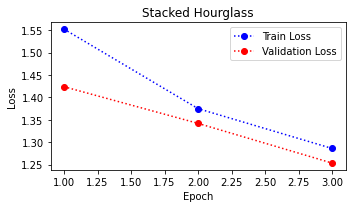

In [56]:
import pickle
import matplotlib.pyplot as plt

# training_history.pkl 파일을 로드
with open('training_history.pkl', 'rb') as f:
    stacked_hrglass_history = pickle.load(f)

# 훈련 및 검증 손실 데이터 추출
train_loss = stacked_hrglass_history.get('train_loss', [])
val_loss = stacked_hrglass_history.get('val_loss', [])

# 에포크 수 추정
epochs = len(train_loss)

# 시각화
plt.figure(figsize=(5, 3))
plt.plot(range(1, epochs + 1), train_loss, 'bo:', label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, 'ro:', label='Validation Loss')
plt.title('Stacked Hourglass')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

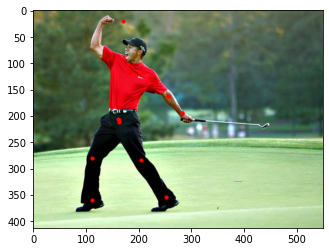

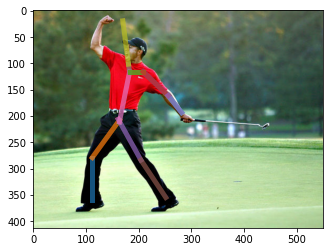

In [52]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

stacked_hrglass_image, stacked_hrglass_keypoints = predict(stacked_hrglass_model, test_image)
draw_keypoints_on_image(stacked_hrglass_image, stacked_hrglass_keypoints)
draw_skeleton_on_image(stacked_hrglass_image, stacked_hrglass_keypoints)

> stackedhourglass 모델을 epochㄴ=3 학습한 후 완벽하지는 않지만 신체의 포인트들을 인지하는 단계에 도달했다.  
epochs를 증대 시 loss가 줄어들 여지가 있고 그러면 사진에서 인물의 오른팔의 관절들이 제대로 인식될 수 있을 것 같다.

# Project

### simplebaseline 모델로 변경해 봅시다
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

### STEP 1 : simplebaseline 모델 완성하기
simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

SimpleBaseline 모델은 크게 세 부분으로 구성됩니다
1. Backbone 네트워크
Backbone 네트워크는 입력 이미지를 특징 맵으로 변환하는 역할을 합니다. 일반적으로 ResNet (Residual Network)을 사용하여 이미지의 고수준 특징을 추출합니다.
2. Deconvolutional 네트워크
Deconvolutional 네트워크는 Backbone 네트워크에서 추출된 특징 맵을 업샘플링하여 원본 이미지와 동일한 해상도의 특징 맵을 만듭니다. 이는 여러 개의 디컨볼루션 (Deconvolution) 층으로 구성됩니다.
3. Heatmap 생성
Deconvolutional 네트워크의 출력을 이용해 각 관절에 대한 Heatmap을 생성합니다. 각 Heatmap은 특정 관절의 존재 가능성을 나타내며, 최종 출력은 여러 개의 Heatmap으로 구성됩니다.

#### SimpleBaseline 모델

In [31]:
import tensorflow as tf
from tensorflow import keras

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for _ in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

def SimpleBaseline(input_shape=(256, 256, 3), 
    num_stack=4, 
    num_residual=1,
    num_heatmap=16):

    inputs = keras.Input(shape=input_shape,dtype=tf.float32)
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    x = resnet(inputs)
    upconv = _make_deconv_layer(3)
    x = upconv(x)
    final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1, 1), padding='same')
    out = final_layer(x)
    out = tf.cast(out, tf.float32)  # float32로 변환
    model = keras.Model(inputs, out, name='simple_baseline')
    return model

# 모델 생성
model = SimpleBaseline()
model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_488 (Conv2D)          (None, 64, 64, 16)        4112      
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 64, 64, 16)        0         
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


SimpleBaseline 모델 'class Trainer()'

In [32]:
class seeifbetter_Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # Initialize history dictionary
        self.history = {'train_loss': [], 'val_loss': []}


    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.
        labels = tf.cast(labels, tf.float32)  # labels를 float32로 변환
        for output in outputs:
            output = tf.cast(output, tf.float32)  # output을 float32로 변환
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        labels = tf.cast(labels, tf.float32)  # labels를 float32로 변환
        images = tf.cast(images, tf.float32)  # images를 float32로 변환
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            outputs = tf.cast(outputs, tf.float32)  # outputs을 float32로 변환
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        labels = tf.cast(labels, tf.float32)  # labels를 float32로 변환
        images = tf.cast(images, tf.float32)  # images를 float32로 변환
        outputs = self.model(images, training=False)
        outputs = tf.cast(outputs, tf.float32)  # outputs을 float32로 변환
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # Save the training and validation loss for each epoch
            self.history['train_loss'].append(train_loss.numpy())
            self.history['val_loss'].append(val_loss.numpy())

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
        
        # Save the history to a file
        with open('seeifbetter_training_history.pkl', 'wb') as f:
            pickle.dump(self.history, f)

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = SEEIFBETTER_MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss) # 수정
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


SimpleBaseline 모델 'train()'적용

In [33]:
def seeifbetter_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(SEEIFBETTER_MODEL_PATH):
        os.makedirs(SEEIFBETTER_MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = SimpleBaseline(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = seeifbetter_Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

SimpleBaseline 모델 학습 

In [34]:
# 실행방법

train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')  
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')  
epochs = 3  
batch_size = 16  
num_heatmap = 16  
learning_rate = 0.0007
seeifbetter_model_file = seeifbetter_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 10.8337641 epoch total loss 10.8337641
Trained batch 2 batch loss 11.4498835 epoch total loss 11.1418238
Trained batch 3 batch loss 9.45336342 epoch total loss 10.5790033
Trained batch 4 batch loss 8.31083393 epoch total loss 10.011961
Trained batch 5 batch loss 7.98801136 epoch total loss 9.60717106
Trained batch 6 batch loss 7.41653585 epoch total loss 9.24206448
Trained batch 7 batch loss 6.84759235 epoch total loss 8.89999676
Trained batch 8 batch loss 6.75164652 epoch total loss 8.63145351
Trained batch 9 batch loss 7.07275963 epoch total loss 8.4582653
Trained batch 10 batch loss 6.18912745 epoch total loss 8.23135185
Trained batch 11 batch loss 6.93164921 epoch total loss 8.11319637
Trained batch 12 batch loss 6.89291668 epoch total loss 8.01150608
Trained batch 13

Trained batch 122 batch loss 6.88495302 epoch total loss 6.68597746
Trained batch 123 batch loss 7.02332783 epoch total loss 6.68872
Trained batch 124 batch loss 6.86376143 epoch total loss 6.69013166
Trained batch 125 batch loss 5.72320032 epoch total loss 6.68239641
Trained batch 126 batch loss 5.50023699 epoch total loss 6.67301416
Trained batch 127 batch loss 6.35389233 epoch total loss 6.67050123
Trained batch 128 batch loss 6.74202156 epoch total loss 6.67106
Trained batch 129 batch loss 6.67833757 epoch total loss 6.67111635
Trained batch 130 batch loss 6.52161 epoch total loss 6.6699667
Trained batch 131 batch loss 6.40884352 epoch total loss 6.66797304
Trained batch 132 batch loss 6.23860264 epoch total loss 6.66472
Trained batch 133 batch loss 6.28680611 epoch total loss 6.66187859
Trained batch 134 batch loss 6.44952202 epoch total loss 6.66029358
Trained batch 135 batch loss 6.39979696 epoch total loss 6.6583643
Trained batch 136 batch loss 5.90248346 epoch total loss 6.652

Trained batch 244 batch loss 6.64455223 epoch total loss 6.54830503
Trained batch 245 batch loss 6.59951878 epoch total loss 6.54851389
Trained batch 246 batch loss 6.51670074 epoch total loss 6.54838467
Trained batch 247 batch loss 6.31816483 epoch total loss 6.54745245
Trained batch 248 batch loss 6.01105547 epoch total loss 6.54528952
Trained batch 249 batch loss 6.30666494 epoch total loss 6.54433107
Trained batch 250 batch loss 6.52005 epoch total loss 6.5442338
Trained batch 251 batch loss 6.18976879 epoch total loss 6.54282188
Trained batch 252 batch loss 6.56142282 epoch total loss 6.54289579
Trained batch 253 batch loss 6.41956377 epoch total loss 6.54240799
Trained batch 254 batch loss 6.66762114 epoch total loss 6.54290104
Trained batch 255 batch loss 6.30005407 epoch total loss 6.5419488
Trained batch 256 batch loss 5.83205795 epoch total loss 6.53917551
Trained batch 257 batch loss 6.22607708 epoch total loss 6.53795719
Trained batch 258 batch loss 6.67864609 epoch total l

Trained batch 366 batch loss 6.77728224 epoch total loss 6.49971914
Trained batch 367 batch loss 6.83798456 epoch total loss 6.50064039
Trained batch 368 batch loss 6.88274765 epoch total loss 6.50167894
Trained batch 369 batch loss 5.78735495 epoch total loss 6.49974346
Trained batch 370 batch loss 6.5299263 epoch total loss 6.499825
Trained batch 371 batch loss 6.793571 epoch total loss 6.50061655
Trained batch 372 batch loss 6.12299156 epoch total loss 6.49960184
Trained batch 373 batch loss 6.45620298 epoch total loss 6.49948549
Trained batch 374 batch loss 6.64354229 epoch total loss 6.49987078
Trained batch 375 batch loss 6.65245295 epoch total loss 6.50027752
Trained batch 376 batch loss 6.36528826 epoch total loss 6.49991798
Trained batch 377 batch loss 6.71389675 epoch total loss 6.5004859
Trained batch 378 batch loss 6.6493516 epoch total loss 6.50088
Trained batch 379 batch loss 6.25669956 epoch total loss 6.50023508
Trained batch 380 batch loss 5.92802715 epoch total loss 6

Trained batch 488 batch loss 6.82775354 epoch total loss 6.48958969
Trained batch 489 batch loss 6.7504859 epoch total loss 6.49012327
Trained batch 490 batch loss 6.41916132 epoch total loss 6.48997831
Trained batch 491 batch loss 6.38697243 epoch total loss 6.48976851
Trained batch 492 batch loss 6.3693552 epoch total loss 6.48952389
Trained batch 493 batch loss 6.55081272 epoch total loss 6.48964787
Trained batch 494 batch loss 6.56829834 epoch total loss 6.48980761
Trained batch 495 batch loss 6.59099722 epoch total loss 6.49001217
Trained batch 496 batch loss 6.19151497 epoch total loss 6.48941
Trained batch 497 batch loss 6.19600153 epoch total loss 6.4888196
Trained batch 498 batch loss 6.36416435 epoch total loss 6.48856974
Trained batch 499 batch loss 6.21456146 epoch total loss 6.48802042
Trained batch 500 batch loss 6.34946156 epoch total loss 6.48774338
Trained batch 501 batch loss 6.61706209 epoch total loss 6.48800087
Trained batch 502 batch loss 6.76363134 epoch total lo

Trained batch 610 batch loss 5.84464312 epoch total loss 6.47429609
Trained batch 611 batch loss 6.39796305 epoch total loss 6.47417116
Trained batch 612 batch loss 6.24242926 epoch total loss 6.47379255
Trained batch 613 batch loss 5.71834278 epoch total loss 6.47256
Trained batch 614 batch loss 5.8675189 epoch total loss 6.47157431
Trained batch 615 batch loss 5.99668169 epoch total loss 6.47080183
Trained batch 616 batch loss 6.00377512 epoch total loss 6.47004366
Trained batch 617 batch loss 6.69432926 epoch total loss 6.47040701
Trained batch 618 batch loss 6.46252918 epoch total loss 6.47039461
Trained batch 619 batch loss 6.52570868 epoch total loss 6.47048378
Trained batch 620 batch loss 6.04107904 epoch total loss 6.46979094
Trained batch 621 batch loss 6.01437521 epoch total loss 6.46905804
Trained batch 622 batch loss 6.34487724 epoch total loss 6.46885824
Trained batch 623 batch loss 6.39841318 epoch total loss 6.46874523
Trained batch 624 batch loss 6.25919151 epoch total 

Trained batch 732 batch loss 6.28469086 epoch total loss 6.4463644
Trained batch 733 batch loss 5.57693481 epoch total loss 6.44517851
Trained batch 734 batch loss 6.00363493 epoch total loss 6.44457674
Trained batch 735 batch loss 6.00999832 epoch total loss 6.44398499
Trained batch 736 batch loss 5.95756245 epoch total loss 6.44332409
Trained batch 737 batch loss 6.11600208 epoch total loss 6.44288
Trained batch 738 batch loss 6.4014082 epoch total loss 6.44282389
Trained batch 739 batch loss 6.22889233 epoch total loss 6.44253492
Trained batch 740 batch loss 6.11938906 epoch total loss 6.44209862
Trained batch 741 batch loss 6.22923 epoch total loss 6.44181061
Trained batch 742 batch loss 6.06630278 epoch total loss 6.44130468
Trained batch 743 batch loss 6.06280518 epoch total loss 6.4407959
Trained batch 744 batch loss 6.36174 epoch total loss 6.44068956
Trained batch 745 batch loss 6.06453943 epoch total loss 6.44018459
Trained batch 746 batch loss 6.24361 epoch total loss 6.4399

Trained batch 854 batch loss 6.89745092 epoch total loss 6.43275118
Trained batch 855 batch loss 5.97445488 epoch total loss 6.43221521
Trained batch 856 batch loss 6.23785162 epoch total loss 6.43198824
Trained batch 857 batch loss 6.51670551 epoch total loss 6.43208694
Trained batch 858 batch loss 6.58797693 epoch total loss 6.43226814
Trained batch 859 batch loss 6.29896498 epoch total loss 6.43211317
Trained batch 860 batch loss 6.37166691 epoch total loss 6.4320426
Trained batch 861 batch loss 6.29838943 epoch total loss 6.43188715
Trained batch 862 batch loss 6.13702 epoch total loss 6.43154526
Trained batch 863 batch loss 6.32739878 epoch total loss 6.43142509
Trained batch 864 batch loss 6.23621464 epoch total loss 6.43119907
Trained batch 865 batch loss 6.31295729 epoch total loss 6.4310627
Trained batch 866 batch loss 6.26149559 epoch total loss 6.4308672
Trained batch 867 batch loss 6.71695709 epoch total loss 6.43119669
Trained batch 868 batch loss 6.69143581 epoch total lo

Trained batch 976 batch loss 6.40946245 epoch total loss 6.41821623
Trained batch 977 batch loss 6.54136467 epoch total loss 6.41834259
Trained batch 978 batch loss 5.75182056 epoch total loss 6.41766119
Trained batch 979 batch loss 6.59406757 epoch total loss 6.41784143
Trained batch 980 batch loss 6.65565681 epoch total loss 6.41808414
Trained batch 981 batch loss 6.29827547 epoch total loss 6.41796207
Trained batch 982 batch loss 6.31421471 epoch total loss 6.41785669
Trained batch 983 batch loss 5.91499758 epoch total loss 6.41734552
Trained batch 984 batch loss 6.35656118 epoch total loss 6.41728354
Trained batch 985 batch loss 6.08407545 epoch total loss 6.41694498
Trained batch 986 batch loss 6.00311232 epoch total loss 6.41652536
Trained batch 987 batch loss 6.25859451 epoch total loss 6.41636562
Trained batch 988 batch loss 5.62167263 epoch total loss 6.41556072
Trained batch 989 batch loss 6.30254 epoch total loss 6.41544676
Trained batch 990 batch loss 5.89006615 epoch total

Trained batch 1096 batch loss 6.58538675 epoch total loss 6.42064953
Trained batch 1097 batch loss 6.72863817 epoch total loss 6.42093
Trained batch 1098 batch loss 6.83884859 epoch total loss 6.4213109
Trained batch 1099 batch loss 6.67316437 epoch total loss 6.42154
Trained batch 1100 batch loss 6.81737566 epoch total loss 6.4219
Trained batch 1101 batch loss 6.65663576 epoch total loss 6.42211294
Trained batch 1102 batch loss 6.4132309 epoch total loss 6.42210484
Trained batch 1103 batch loss 5.50749493 epoch total loss 6.42127562
Trained batch 1104 batch loss 5.59921408 epoch total loss 6.4205308
Trained batch 1105 batch loss 5.27147436 epoch total loss 6.41949081
Trained batch 1106 batch loss 5.82918072 epoch total loss 6.41895723
Trained batch 1107 batch loss 6.04191399 epoch total loss 6.41861677
Trained batch 1108 batch loss 6.30900908 epoch total loss 6.41851807
Trained batch 1109 batch loss 6.17503738 epoch total loss 6.41829824
Trained batch 1110 batch loss 6.58552551 epoch 

Trained batch 1216 batch loss 5.60827732 epoch total loss 6.42000532
Trained batch 1217 batch loss 6.08376932 epoch total loss 6.41972923
Trained batch 1218 batch loss 6.37680864 epoch total loss 6.41969395
Trained batch 1219 batch loss 6.31890249 epoch total loss 6.41961145
Trained batch 1220 batch loss 6.42048359 epoch total loss 6.41961193
Trained batch 1221 batch loss 6.60805702 epoch total loss 6.41976643
Trained batch 1222 batch loss 6.57023716 epoch total loss 6.41988945
Trained batch 1223 batch loss 6.53864431 epoch total loss 6.41998672
Trained batch 1224 batch loss 6.3178153 epoch total loss 6.41990328
Trained batch 1225 batch loss 6.52361727 epoch total loss 6.41998768
Trained batch 1226 batch loss 6.42428875 epoch total loss 6.41999102
Trained batch 1227 batch loss 6.37207317 epoch total loss 6.41995192
Trained batch 1228 batch loss 6.70690203 epoch total loss 6.42018604
Trained batch 1229 batch loss 6.60211325 epoch total loss 6.42033386
Trained batch 1230 batch loss 6.740

Trained batch 1336 batch loss 6.22511435 epoch total loss 6.42425919
Trained batch 1337 batch loss 6.20600224 epoch total loss 6.42409611
Trained batch 1338 batch loss 6.49811363 epoch total loss 6.42415142
Trained batch 1339 batch loss 6.12394857 epoch total loss 6.42392731
Trained batch 1340 batch loss 5.74080229 epoch total loss 6.42341805
Trained batch 1341 batch loss 6.29597569 epoch total loss 6.42332268
Trained batch 1342 batch loss 6.28271437 epoch total loss 6.42321777
Trained batch 1343 batch loss 6.25114632 epoch total loss 6.4230895
Trained batch 1344 batch loss 5.90764332 epoch total loss 6.42270565
Trained batch 1345 batch loss 6.53247547 epoch total loss 6.42278671
Trained batch 1346 batch loss 6.18791771 epoch total loss 6.42261219
Trained batch 1347 batch loss 6.05347586 epoch total loss 6.42233849
Trained batch 1348 batch loss 6.3492012 epoch total loss 6.42228413
Trained batch 1349 batch loss 6.1289 epoch total loss 6.42206669
Trained batch 1350 batch loss 6.1074357 

Validated batch 112 batch loss 6.37421179
Validated batch 113 batch loss 6.38923311
Validated batch 114 batch loss 6.39233732
Validated batch 115 batch loss 6.14487696
Validated batch 116 batch loss 6.51810884
Validated batch 117 batch loss 6.25113583
Validated batch 118 batch loss 6.1581254
Validated batch 119 batch loss 6.17691565
Validated batch 120 batch loss 6.38668585
Validated batch 121 batch loss 6.35531855
Validated batch 122 batch loss 6.32211924
Validated batch 123 batch loss 6.3869586
Validated batch 124 batch loss 6.19103622
Validated batch 125 batch loss 6.45693254
Validated batch 126 batch loss 6.77726221
Validated batch 127 batch loss 6.55969715
Validated batch 128 batch loss 6.26515102
Validated batch 129 batch loss 6.29038382
Validated batch 130 batch loss 6.40063238
Validated batch 131 batch loss 6.27204037
Validated batch 132 batch loss 6.60439444
Validated batch 133 batch loss 6.10511923
Validated batch 134 batch loss 6.44063091
Validated batch 135 batch loss 6.237

Trained batch 75 batch loss 6.57810354 epoch total loss 6.25085592
Trained batch 76 batch loss 6.20978308 epoch total loss 6.25031519
Trained batch 77 batch loss 6.42565632 epoch total loss 6.25259256
Trained batch 78 batch loss 6.44171 epoch total loss 6.2550168
Trained batch 79 batch loss 6.64231062 epoch total loss 6.25991917
Trained batch 80 batch loss 6.43517303 epoch total loss 6.26211
Trained batch 81 batch loss 6.84463644 epoch total loss 6.26930189
Trained batch 82 batch loss 6.76110935 epoch total loss 6.2753
Trained batch 83 batch loss 6.43281507 epoch total loss 6.27719736
Trained batch 84 batch loss 6.47838211 epoch total loss 6.27959251
Trained batch 85 batch loss 6.58384323 epoch total loss 6.28317213
Trained batch 86 batch loss 6.73945284 epoch total loss 6.2884779
Trained batch 87 batch loss 6.32564592 epoch total loss 6.28890467
Trained batch 88 batch loss 6.27288437 epoch total loss 6.28872252
Trained batch 89 batch loss 5.96796513 epoch total loss 6.28511858
Trained

Trained batch 197 batch loss 6.52114 epoch total loss 6.32184792
Trained batch 198 batch loss 6.60442448 epoch total loss 6.32327509
Trained batch 199 batch loss 6.50054359 epoch total loss 6.32416534
Trained batch 200 batch loss 6.3683238 epoch total loss 6.32438612
Trained batch 201 batch loss 6.37102461 epoch total loss 6.32461786
Trained batch 202 batch loss 6.31054306 epoch total loss 6.32454824
Trained batch 203 batch loss 6.30673885 epoch total loss 6.32446051
Trained batch 204 batch loss 6.19288588 epoch total loss 6.32381535
Trained batch 205 batch loss 6.20784712 epoch total loss 6.32325
Trained batch 206 batch loss 6.1713748 epoch total loss 6.32251263
Trained batch 207 batch loss 6.59604836 epoch total loss 6.32383442
Trained batch 208 batch loss 6.41825056 epoch total loss 6.32428789
Trained batch 209 batch loss 6.22572708 epoch total loss 6.3238163
Trained batch 210 batch loss 6.08605957 epoch total loss 6.32268429
Trained batch 211 batch loss 6.29503059 epoch total loss 

Trained batch 319 batch loss 5.89112663 epoch total loss 6.33454895
Trained batch 320 batch loss 6.33354712 epoch total loss 6.33454561
Trained batch 321 batch loss 6.19240427 epoch total loss 6.33410263
Trained batch 322 batch loss 6.4219346 epoch total loss 6.33437538
Trained batch 323 batch loss 6.72270203 epoch total loss 6.33557749
Trained batch 324 batch loss 6.55581474 epoch total loss 6.33625698
Trained batch 325 batch loss 6.17454243 epoch total loss 6.33575964
Trained batch 326 batch loss 6.14902163 epoch total loss 6.33518648
Trained batch 327 batch loss 6.41032791 epoch total loss 6.33541632
Trained batch 328 batch loss 6.44690084 epoch total loss 6.33575678
Trained batch 329 batch loss 6.43453789 epoch total loss 6.33605719
Trained batch 330 batch loss 6.4823885 epoch total loss 6.33650064
Trained batch 331 batch loss 6.38967085 epoch total loss 6.33666086
Trained batch 332 batch loss 6.2287941 epoch total loss 6.33633614
Trained batch 333 batch loss 6.44568729 epoch total

Trained batch 441 batch loss 5.99823236 epoch total loss 6.34880877
Trained batch 442 batch loss 6.18605042 epoch total loss 6.34844065
Trained batch 443 batch loss 6.34007025 epoch total loss 6.34842157
Trained batch 444 batch loss 6.24796295 epoch total loss 6.34819555
Trained batch 445 batch loss 6.57650471 epoch total loss 6.34870863
Trained batch 446 batch loss 6.32122087 epoch total loss 6.34864712
Trained batch 447 batch loss 6.41905642 epoch total loss 6.34880447
Trained batch 448 batch loss 6.5917182 epoch total loss 6.34934664
Trained batch 449 batch loss 6.75576925 epoch total loss 6.35025215
Trained batch 450 batch loss 6.63042736 epoch total loss 6.35087442
Trained batch 451 batch loss 6.55401945 epoch total loss 6.35132504
Trained batch 452 batch loss 6.32232094 epoch total loss 6.35126066
Trained batch 453 batch loss 6.4229188 epoch total loss 6.3514185
Trained batch 454 batch loss 5.82497358 epoch total loss 6.35025883
Trained batch 455 batch loss 6.40279484 epoch total

Trained batch 563 batch loss 6.89291143 epoch total loss 6.36081648
Trained batch 564 batch loss 6.59716034 epoch total loss 6.36123562
Trained batch 565 batch loss 6.56729937 epoch total loss 6.3616004
Trained batch 566 batch loss 6.5664897 epoch total loss 6.36196232
Trained batch 567 batch loss 6.70376635 epoch total loss 6.36256504
Trained batch 568 batch loss 6.73002672 epoch total loss 6.36321211
Trained batch 569 batch loss 6.61416435 epoch total loss 6.36365318
Trained batch 570 batch loss 6.57448816 epoch total loss 6.36402321
Trained batch 571 batch loss 6.64008045 epoch total loss 6.36450672
Trained batch 572 batch loss 6.62860823 epoch total loss 6.3649683
Trained batch 573 batch loss 6.59409046 epoch total loss 6.36536837
Trained batch 574 batch loss 6.53700924 epoch total loss 6.36566734
Trained batch 575 batch loss 6.56003189 epoch total loss 6.36600542
Trained batch 576 batch loss 6.47773457 epoch total loss 6.36619949
Trained batch 577 batch loss 6.46348286 epoch total

Trained batch 685 batch loss 6.59802294 epoch total loss 6.37635279
Trained batch 686 batch loss 6.54278278 epoch total loss 6.37659597
Trained batch 687 batch loss 6.50671816 epoch total loss 6.37678528
Trained batch 688 batch loss 6.71971464 epoch total loss 6.37728405
Trained batch 689 batch loss 6.44173956 epoch total loss 6.37737751
Trained batch 690 batch loss 6.30444527 epoch total loss 6.37727213
Trained batch 691 batch loss 5.96056604 epoch total loss 6.37666893
Trained batch 692 batch loss 6.20719814 epoch total loss 6.37642384
Trained batch 693 batch loss 6.35321331 epoch total loss 6.37639
Trained batch 694 batch loss 6.1174655 epoch total loss 6.37601757
Trained batch 695 batch loss 6.32369 epoch total loss 6.37594223
Trained batch 696 batch loss 6.20679331 epoch total loss 6.37569952
Trained batch 697 batch loss 6.28915 epoch total loss 6.37557507
Trained batch 698 batch loss 6.08673763 epoch total loss 6.37516165
Trained batch 699 batch loss 6.31078815 epoch total loss 6

Trained batch 807 batch loss 6.440835 epoch total loss 6.3820715
Trained batch 808 batch loss 6.45364618 epoch total loss 6.38215971
Trained batch 809 batch loss 6.60368967 epoch total loss 6.38243341
Trained batch 810 batch loss 6.37846661 epoch total loss 6.38242865
Trained batch 811 batch loss 5.86232 epoch total loss 6.3817873
Trained batch 812 batch loss 6.23823786 epoch total loss 6.38161039
Trained batch 813 batch loss 6.48938704 epoch total loss 6.38174295
Trained batch 814 batch loss 6.0289855 epoch total loss 6.38130903
Trained batch 815 batch loss 6.24494553 epoch total loss 6.38114214
Trained batch 816 batch loss 5.80281544 epoch total loss 6.38043356
Trained batch 817 batch loss 6.05806494 epoch total loss 6.38003874
Trained batch 818 batch loss 6.3076992 epoch total loss 6.37995
Trained batch 819 batch loss 6.32476807 epoch total loss 6.37988281
Trained batch 820 batch loss 6.58457041 epoch total loss 6.3801322
Trained batch 821 batch loss 6.81135607 epoch total loss 6.38

Trained batch 929 batch loss 6.71636772 epoch total loss 6.37767124
Trained batch 930 batch loss 6.64209795 epoch total loss 6.37795544
Trained batch 931 batch loss 6.13270521 epoch total loss 6.37769222
Trained batch 932 batch loss 6.58317 epoch total loss 6.37791252
Trained batch 933 batch loss 6.79571247 epoch total loss 6.37836027
Trained batch 934 batch loss 6.47273922 epoch total loss 6.37846136
Trained batch 935 batch loss 6.19705963 epoch total loss 6.37826777
Trained batch 936 batch loss 6.50243521 epoch total loss 6.37840033
Trained batch 937 batch loss 6.21252823 epoch total loss 6.37822294
Trained batch 938 batch loss 6.20913553 epoch total loss 6.3780427
Trained batch 939 batch loss 5.96106339 epoch total loss 6.37759829
Trained batch 940 batch loss 6.16986418 epoch total loss 6.37737751
Trained batch 941 batch loss 6.17866325 epoch total loss 6.37716627
Trained batch 942 batch loss 6.37530327 epoch total loss 6.37716484
Trained batch 943 batch loss 6.27100134 epoch total 

Trained batch 1050 batch loss 6.31430626 epoch total loss 6.3682785
Trained batch 1051 batch loss 6.48663044 epoch total loss 6.36839104
Trained batch 1052 batch loss 6.63805676 epoch total loss 6.36864758
Trained batch 1053 batch loss 6.45589972 epoch total loss 6.36873055
Trained batch 1054 batch loss 5.97434568 epoch total loss 6.36835623
Trained batch 1055 batch loss 6.19724655 epoch total loss 6.3681941
Trained batch 1056 batch loss 6.33529568 epoch total loss 6.36816311
Trained batch 1057 batch loss 6.36825275 epoch total loss 6.36816311
Trained batch 1058 batch loss 6.21237946 epoch total loss 6.36801577
Trained batch 1059 batch loss 6.18583202 epoch total loss 6.3678441
Trained batch 1060 batch loss 6.33089876 epoch total loss 6.3678093
Trained batch 1061 batch loss 6.18315649 epoch total loss 6.36763525
Trained batch 1062 batch loss 6.23743296 epoch total loss 6.3675127
Trained batch 1063 batch loss 6.33787775 epoch total loss 6.36748457
Trained batch 1064 batch loss 6.4533538

Trained batch 1170 batch loss 6.61497927 epoch total loss 6.36876106
Trained batch 1171 batch loss 6.49849892 epoch total loss 6.36887217
Trained batch 1172 batch loss 6.10377645 epoch total loss 6.36864614
Trained batch 1173 batch loss 6.37507772 epoch total loss 6.36865139
Trained batch 1174 batch loss 6.3289 epoch total loss 6.36861801
Trained batch 1175 batch loss 6.672122 epoch total loss 6.36887646
Trained batch 1176 batch loss 6.11714268 epoch total loss 6.36866236
Trained batch 1177 batch loss 6.44152498 epoch total loss 6.36872435
Trained batch 1178 batch loss 6.44922972 epoch total loss 6.36879253
Trained batch 1179 batch loss 6.13478041 epoch total loss 6.36859417
Trained batch 1180 batch loss 6.0779376 epoch total loss 6.36834764
Trained batch 1181 batch loss 6.23011494 epoch total loss 6.36823082
Trained batch 1182 batch loss 6.28023291 epoch total loss 6.36815643
Trained batch 1183 batch loss 6.67182779 epoch total loss 6.36841297
Trained batch 1184 batch loss 6.71635771 

Trained batch 1290 batch loss 6.14819527 epoch total loss 6.37164
Trained batch 1291 batch loss 6.23318481 epoch total loss 6.37153339
Trained batch 1292 batch loss 6.46855688 epoch total loss 6.37160826
Trained batch 1293 batch loss 6.64716482 epoch total loss 6.37182188
Trained batch 1294 batch loss 6.31303787 epoch total loss 6.37177658
Trained batch 1295 batch loss 5.37513256 epoch total loss 6.37100697
Trained batch 1296 batch loss 4.49436283 epoch total loss 6.36955881
Trained batch 1297 batch loss 5.8093729 epoch total loss 6.36912727
Trained batch 1298 batch loss 7.06337929 epoch total loss 6.36966181
Trained batch 1299 batch loss 7.30957556 epoch total loss 6.37038565
Trained batch 1300 batch loss 6.69703627 epoch total loss 6.37063694
Trained batch 1301 batch loss 6.37228489 epoch total loss 6.37063789
Trained batch 1302 batch loss 6.13000393 epoch total loss 6.37045336
Trained batch 1303 batch loss 6.13191462 epoch total loss 6.37027025
Trained batch 1304 batch loss 6.330208

Validated batch 36 batch loss 6.1805644
Validated batch 37 batch loss 6.16688681
Validated batch 38 batch loss 6.21904755
Validated batch 39 batch loss 6.29670238
Validated batch 40 batch loss 6.27889776
Validated batch 41 batch loss 6.50851059
Validated batch 42 batch loss 6.27650547
Validated batch 43 batch loss 6.10449314
Validated batch 44 batch loss 6.58051491
Validated batch 45 batch loss 5.37794781
Validated batch 46 batch loss 6.69277716
Validated batch 47 batch loss 6.22690725
Validated batch 48 batch loss 5.89140272
Validated batch 49 batch loss 6.28222275
Validated batch 50 batch loss 6.25668573
Validated batch 51 batch loss 6.2018652
Validated batch 52 batch loss 6.56681299
Validated batch 53 batch loss 6.45848513
Validated batch 54 batch loss 6.39884949
Validated batch 55 batch loss 6.37764406
Validated batch 56 batch loss 6.40687418
Validated batch 57 batch loss 6.13017654
Validated batch 58 batch loss 6.3789506
Validated batch 59 batch loss 6.21148348
Validated batch 60 

Trained batch 29 batch loss 6.12189579 epoch total loss 6.4297595
Trained batch 30 batch loss 6.35647774 epoch total loss 6.42731667
Trained batch 31 batch loss 6.50309277 epoch total loss 6.42976141
Trained batch 32 batch loss 6.74900484 epoch total loss 6.4397378
Trained batch 33 batch loss 6.5546751 epoch total loss 6.44322062
Trained batch 34 batch loss 6.57750654 epoch total loss 6.44717026
Trained batch 35 batch loss 6.55063152 epoch total loss 6.45012617
Trained batch 36 batch loss 6.51201582 epoch total loss 6.45184517
Trained batch 37 batch loss 6.60404539 epoch total loss 6.45595837
Trained batch 38 batch loss 6.37654591 epoch total loss 6.45386887
Trained batch 39 batch loss 6.26865 epoch total loss 6.44911957
Trained batch 40 batch loss 6.5001049 epoch total loss 6.45039368
Trained batch 41 batch loss 6.9172 epoch total loss 6.46177912
Trained batch 42 batch loss 6.27923727 epoch total loss 6.45743322
Trained batch 43 batch loss 5.76220608 epoch total loss 6.44126511
Traine

Trained batch 152 batch loss 6.42990065 epoch total loss 6.42691708
Trained batch 153 batch loss 6.43190479 epoch total loss 6.4269495
Trained batch 154 batch loss 6.35042 epoch total loss 6.42645264
Trained batch 155 batch loss 6.44346523 epoch total loss 6.42656231
Trained batch 156 batch loss 5.93431616 epoch total loss 6.42340708
Trained batch 157 batch loss 6.33716393 epoch total loss 6.42285776
Trained batch 158 batch loss 6.30684805 epoch total loss 6.42212343
Trained batch 159 batch loss 6.0709281 epoch total loss 6.41991472
Trained batch 160 batch loss 6.60542488 epoch total loss 6.42107391
Trained batch 161 batch loss 6.45185804 epoch total loss 6.4212656
Trained batch 162 batch loss 6.04005909 epoch total loss 6.41891193
Trained batch 163 batch loss 6.52155638 epoch total loss 6.41954231
Trained batch 164 batch loss 6.57391119 epoch total loss 6.42048311
Trained batch 165 batch loss 6.52918196 epoch total loss 6.42114162
Trained batch 166 batch loss 6.83050203 epoch total lo

Trained batch 274 batch loss 6.04408121 epoch total loss 6.40869141
Trained batch 275 batch loss 6.14165592 epoch total loss 6.40772
Trained batch 276 batch loss 6.18285465 epoch total loss 6.40690565
Trained batch 277 batch loss 6.41931248 epoch total loss 6.40695047
Trained batch 278 batch loss 6.26447105 epoch total loss 6.40643787
Trained batch 279 batch loss 6.41927195 epoch total loss 6.40648413
Trained batch 280 batch loss 6.36376286 epoch total loss 6.40633154
Trained batch 281 batch loss 6.11776733 epoch total loss 6.40530491
Trained batch 282 batch loss 5.62761688 epoch total loss 6.40254688
Trained batch 283 batch loss 5.3884263 epoch total loss 6.39896345
Trained batch 284 batch loss 5.76711845 epoch total loss 6.39673853
Trained batch 285 batch loss 6.21443319 epoch total loss 6.39609909
Trained batch 286 batch loss 6.61320829 epoch total loss 6.39685774
Trained batch 287 batch loss 6.9024539 epoch total loss 6.39861965
Trained batch 288 batch loss 6.52702808 epoch total l

Trained batch 396 batch loss 6.09388494 epoch total loss 6.39783144
Trained batch 397 batch loss 5.9597187 epoch total loss 6.39672804
Trained batch 398 batch loss 6.08875132 epoch total loss 6.39595461
Trained batch 399 batch loss 6.13519812 epoch total loss 6.39530087
Trained batch 400 batch loss 6.0162406 epoch total loss 6.39435387
Trained batch 401 batch loss 6.16009712 epoch total loss 6.39376974
Trained batch 402 batch loss 6.0171895 epoch total loss 6.39283276
Trained batch 403 batch loss 6.03761816 epoch total loss 6.39195108
Trained batch 404 batch loss 6.01145887 epoch total loss 6.39100933
Trained batch 405 batch loss 5.8129282 epoch total loss 6.38958216
Trained batch 406 batch loss 6.35272503 epoch total loss 6.38949156
Trained batch 407 batch loss 6.10242176 epoch total loss 6.38878632
Trained batch 408 batch loss 6.42647028 epoch total loss 6.38887882
Trained batch 409 batch loss 6.36063433 epoch total loss 6.38880968
Trained batch 410 batch loss 6.60201025 epoch total 

Trained batch 518 batch loss 6.43635368 epoch total loss 6.37323284
Trained batch 519 batch loss 6.76138735 epoch total loss 6.373981
Trained batch 520 batch loss 7.34162951 epoch total loss 6.37584162
Trained batch 521 batch loss 7.03082609 epoch total loss 6.37709904
Trained batch 522 batch loss 6.83718109 epoch total loss 6.37798
Trained batch 523 batch loss 6.25945187 epoch total loss 6.37775373
Trained batch 524 batch loss 6.12966824 epoch total loss 6.37728
Trained batch 525 batch loss 6.79566908 epoch total loss 6.37807703
Trained batch 526 batch loss 6.47060061 epoch total loss 6.37825298
Trained batch 527 batch loss 6.59562302 epoch total loss 6.37866592
Trained batch 528 batch loss 6.44693756 epoch total loss 6.37879515
Trained batch 529 batch loss 5.96822548 epoch total loss 6.37801933
Trained batch 530 batch loss 5.79724741 epoch total loss 6.37692356
Trained batch 531 batch loss 5.54481554 epoch total loss 6.37535667
Trained batch 532 batch loss 5.77910423 epoch total loss

Trained batch 640 batch loss 6.61632 epoch total loss 6.37541103
Trained batch 641 batch loss 6.24907 epoch total loss 6.3752141
Trained batch 642 batch loss 6.32724142 epoch total loss 6.37513924
Trained batch 643 batch loss 5.88613605 epoch total loss 6.37437868
Trained batch 644 batch loss 6.3115139 epoch total loss 6.37428141
Trained batch 645 batch loss 6.5085206 epoch total loss 6.37448883
Trained batch 646 batch loss 6.354321 epoch total loss 6.37445784
Trained batch 647 batch loss 6.03299809 epoch total loss 6.37393045
Trained batch 648 batch loss 6.31516504 epoch total loss 6.37383938
Trained batch 649 batch loss 6.27495193 epoch total loss 6.37368727
Trained batch 650 batch loss 6.36163044 epoch total loss 6.37366867
Trained batch 651 batch loss 6.40655279 epoch total loss 6.37371969
Trained batch 652 batch loss 6.37700129 epoch total loss 6.37372446
Trained batch 653 batch loss 6.00397778 epoch total loss 6.37315845
Trained batch 654 batch loss 6.35160398 epoch total loss 6.

Trained batch 762 batch loss 6.94872475 epoch total loss 6.3647027
Trained batch 763 batch loss 6.45818186 epoch total loss 6.36482477
Trained batch 764 batch loss 6.62734032 epoch total loss 6.36516857
Trained batch 765 batch loss 6.80652761 epoch total loss 6.36574554
Trained batch 766 batch loss 6.44544029 epoch total loss 6.36584949
Trained batch 767 batch loss 6.5864253 epoch total loss 6.36613703
Trained batch 768 batch loss 6.72193718 epoch total loss 6.36660051
Trained batch 769 batch loss 6.90713596 epoch total loss 6.36730385
Trained batch 770 batch loss 6.80093098 epoch total loss 6.36786652
Trained batch 771 batch loss 6.62643719 epoch total loss 6.36820221
Trained batch 772 batch loss 6.58814287 epoch total loss 6.36848736
Trained batch 773 batch loss 6.62069321 epoch total loss 6.36881351
Trained batch 774 batch loss 6.28682709 epoch total loss 6.36870718
Trained batch 775 batch loss 6.65806341 epoch total loss 6.36908054
Trained batch 776 batch loss 6.50001335 epoch tota

Trained batch 884 batch loss 6.9765172 epoch total loss 6.36435461
Trained batch 885 batch loss 5.94277096 epoch total loss 6.36387825
Trained batch 886 batch loss 5.64025 epoch total loss 6.36306143
Trained batch 887 batch loss 5.33018637 epoch total loss 6.36189699
Trained batch 888 batch loss 5.36106253 epoch total loss 6.36076927
Trained batch 889 batch loss 5.28049946 epoch total loss 6.35955429
Trained batch 890 batch loss 5.31395817 epoch total loss 6.35837936
Trained batch 891 batch loss 5.9246769 epoch total loss 6.35789251
Trained batch 892 batch loss 6.36122799 epoch total loss 6.35789633
Trained batch 893 batch loss 6.37318659 epoch total loss 6.35791349
Trained batch 894 batch loss 6.71378708 epoch total loss 6.35831165
Trained batch 895 batch loss 6.20753384 epoch total loss 6.35814333
Trained batch 896 batch loss 6.30623102 epoch total loss 6.35808516
Trained batch 897 batch loss 5.82373428 epoch total loss 6.35748959
Trained batch 898 batch loss 6.25936079 epoch total l

Trained batch 1006 batch loss 6.52634287 epoch total loss 6.35695601
Trained batch 1007 batch loss 6.77316093 epoch total loss 6.35736895
Trained batch 1008 batch loss 6.23736238 epoch total loss 6.35724974
Trained batch 1009 batch loss 6.62742329 epoch total loss 6.35751772
Trained batch 1010 batch loss 6.53890228 epoch total loss 6.35769749
Trained batch 1011 batch loss 6.46745586 epoch total loss 6.35780573
Trained batch 1012 batch loss 6.33827686 epoch total loss 6.35778666
Trained batch 1013 batch loss 6.3541255 epoch total loss 6.35778284
Trained batch 1014 batch loss 6.26306915 epoch total loss 6.35768938
Trained batch 1015 batch loss 5.95679283 epoch total loss 6.35729504
Trained batch 1016 batch loss 6.22885418 epoch total loss 6.35716867
Trained batch 1017 batch loss 5.95151186 epoch total loss 6.35677
Trained batch 1018 batch loss 5.97807264 epoch total loss 6.35639763
Trained batch 1019 batch loss 6.13202953 epoch total loss 6.35617733
Trained batch 1020 batch loss 6.504812

Trained batch 1126 batch loss 5.79894829 epoch total loss 6.35333538
Trained batch 1127 batch loss 6.5416379 epoch total loss 6.35350227
Trained batch 1128 batch loss 6.50569153 epoch total loss 6.35363722
Trained batch 1129 batch loss 6.38673 epoch total loss 6.35366678
Trained batch 1130 batch loss 6.19121599 epoch total loss 6.35352278
Trained batch 1131 batch loss 6.54932117 epoch total loss 6.35369587
Trained batch 1132 batch loss 6.30881882 epoch total loss 6.35365629
Trained batch 1133 batch loss 6.30769873 epoch total loss 6.35361576
Trained batch 1134 batch loss 6.5352459 epoch total loss 6.3537755
Trained batch 1135 batch loss 6.27853584 epoch total loss 6.35370922
Trained batch 1136 batch loss 6.51799726 epoch total loss 6.3538537
Trained batch 1137 batch loss 6.41753674 epoch total loss 6.35391
Trained batch 1138 batch loss 6.5937686 epoch total loss 6.35412073
Trained batch 1139 batch loss 6.24346399 epoch total loss 6.35402346
Trained batch 1140 batch loss 6.47107601 epoc

Trained batch 1246 batch loss 6.62499142 epoch total loss 6.34880972
Trained batch 1247 batch loss 6.27148724 epoch total loss 6.34874773
Trained batch 1248 batch loss 6.51642895 epoch total loss 6.3488822
Trained batch 1249 batch loss 5.95383692 epoch total loss 6.34856606
Trained batch 1250 batch loss 6.05533504 epoch total loss 6.34833145
Trained batch 1251 batch loss 6.21808195 epoch total loss 6.3482275
Trained batch 1252 batch loss 6.32503796 epoch total loss 6.3482089
Trained batch 1253 batch loss 6.32287169 epoch total loss 6.3481884
Trained batch 1254 batch loss 6.4216485 epoch total loss 6.34824753
Trained batch 1255 batch loss 6.38141775 epoch total loss 6.34827375
Trained batch 1256 batch loss 6.3209939 epoch total loss 6.34825182
Trained batch 1257 batch loss 6.32073164 epoch total loss 6.34823
Trained batch 1258 batch loss 6.49210739 epoch total loss 6.34834433
Trained batch 1259 batch loss 6.56462908 epoch total loss 6.34851599
Trained batch 1260 batch loss 6.91521645 ep

Trained batch 1366 batch loss 6.40492678 epoch total loss 6.35591698
Trained batch 1367 batch loss 6.49770308 epoch total loss 6.35602093
Trained batch 1368 batch loss 6.62694454 epoch total loss 6.35621881
Trained batch 1369 batch loss 6.40308666 epoch total loss 6.35625362
Trained batch 1370 batch loss 6.53299522 epoch total loss 6.35638237
Trained batch 1371 batch loss 6.53721237 epoch total loss 6.35651445
Trained batch 1372 batch loss 6.56547165 epoch total loss 6.35666656
Trained batch 1373 batch loss 6.61488533 epoch total loss 6.35685492
Trained batch 1374 batch loss 6.59229231 epoch total loss 6.35702658
Trained batch 1375 batch loss 6.57128525 epoch total loss 6.3571825
Trained batch 1376 batch loss 6.49975967 epoch total loss 6.35728645
Trained batch 1377 batch loss 6.46949196 epoch total loss 6.35736799
Trained batch 1378 batch loss 6.54400301 epoch total loss 6.35750341
Trained batch 1379 batch loss 6.46493 epoch total loss 6.35758114
Trained batch 1380 batch loss 6.552451

Validated batch 162 batch loss 6.3539772
Validated batch 163 batch loss 6.82403469
Validated batch 164 batch loss 6.34607315
Validated batch 165 batch loss 5.8307209
Validated batch 166 batch loss 6.29563475
Validated batch 167 batch loss 6.24547291
Validated batch 168 batch loss 6.06411028
Validated batch 169 batch loss 5.98778343
Validated batch 170 batch loss 5.89252806
Validated batch 171 batch loss 6.60819626
Validated batch 172 batch loss 6.20515633
Validated batch 173 batch loss 6.03095675
Validated batch 174 batch loss 5.87103653
Validated batch 175 batch loss 6.59801912
Validated batch 176 batch loss 6.00864267
Validated batch 177 batch loss 6.22350454
Validated batch 178 batch loss 6.31496668
Validated batch 179 batch loss 6.52995
Validated batch 180 batch loss 6.16286
Validated batch 181 batch loss 6.44852114
Validated batch 182 batch loss 6.59041309
Validated batch 183 batch loss 5.67185354
Validated batch 184 batch loss 6.17700291
Validated batch 185 batch loss 3.59888744


In [54]:
simplebl_model = SimpleBaseline(IMAGE_SHAPE, 4, 1)

# model.load_weights(best_model_file) # best_model_file생성 후 바로 사용 시
SEEIFBETTER_MODEL_PATH = os.path.join(PROJECT_PATH, 'seeifbetter_models','model-epoch-2-loss-6.2995.h5')
simplebl_model.load_weights(SEEIFBETTER_MODEL_PATH)

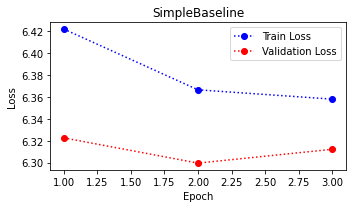

In [59]:
import pickle
import matplotlib.pyplot as plt

# training_history.pkl 파일을 로드
with open('seeifbetter_training_history.pkl', 'rb') as f:
    simplebl_history = pickle.load(f)

# 훈련 및 검증 손실 데이터 추출
train_loss = simplebl_history.get('train_loss', [])
val_loss = simplebl_history.get('val_loss', [])

# 에포크 수 추정
epochs = len(train_loss)

# 시각화
plt.figure(figsize=(5, 3))
plt.plot(range(1, epochs + 1), train_loss, 'bo:', label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, 'ro:', label='Validation Loss')
plt.title('SimpleBaseline')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

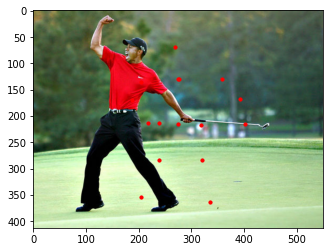

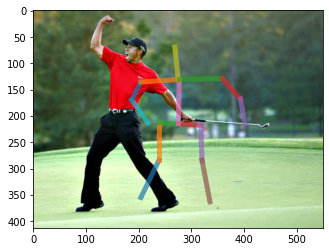

In [55]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

simplebl_image, simplebl_keypoints = predict(simplebl_model, test_image)
draw_keypoints_on_image(simplebl_image, simplebl_keypoints)
draw_skeleton_on_image(simplebl_image, simplebl_keypoints)

> **TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'** 가 해결되지 않는다.

### STEP 3 : 두 모델의 비교
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.
* Pose Estimation 결과 시각화 (정성적 비교)
* 학습 진행 경과 (loss 감소 현황)

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

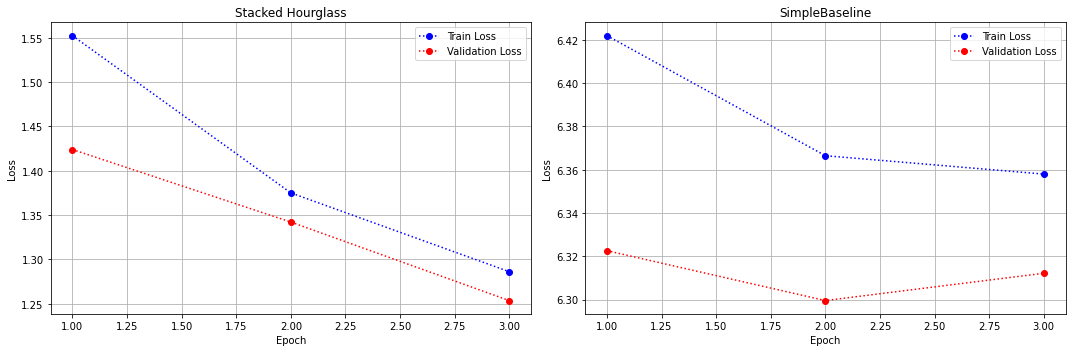

In [42]:
import pickle
import matplotlib.pyplot as plt

# training_history.pkl 파일을 로드
with open('training_history.pkl', 'rb') as f:
    stacked_hrglass_history = pickle.load(f)

# 훈련 및 검증 손실 데이터 추출
stacked_hrglass_train_loss = stacked_hrglass_history.get('train_loss', [])
stacked_hrglass_val_loss = stacked_hrglass_history.get('val_loss', [])

# seeifbetter_training_history.pkl 파일을 로드
with open('seeifbetter_training_history.pkl', 'rb') as f:
    simplebl_history = pickle.load(f)

# 훈련 및 검증 손실 데이터 추출
simplebl_train_loss = simplebl_history.get('train_loss', [])
simplebl_val_loss = simplebl_history.get('val_loss', [])

# 에포크 수 추정
epochs = len(stacked_hrglass_train_loss)


# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Stacked Hourglass
axes[0].plot(range(1,epochs + 1), stacked_hrglass_train_loss, 'bo:', label='Train Loss')
axes[0].plot(range(1,epochs + 1), stacked_hrglass_val_loss, 'ro:', label='Validation Loss')
axes[0].set_title('Stacked Hourglass')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# SimpleBaseline
axes[1].plot(range(1, epochs + 1), simplebl_train_loss, 'bo:', label='Train Loss')
axes[1].plot(range(1, epochs + 1), simplebl_val_loss, 'ro:', label='Validation Loss')
axes[1].set_title('SimpleBaseline')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


> 예상과 다르게 epochs=3 조건에서는 SimpleBaseline 모델이 Stcked Hourglass 모델보다 열악한 결과를 나타냈다. 

# 회고
* model이 customized 방식이라서 신경써야 될 부분이 상당히 많았다.
* 시간제약 상 epochs을 3회로 제한했다.
* model의 시각화를 위해 loss를 저장하는 부분을 추가했다.
* 모델비교를 위해 공통부분을 수정해서 사용한 후 에러가 발생해서, 복제된 파일에서 model부분만 SimpleBaseline으로 변경해도 다음의 에러가 해결이 어려웠다. compute_loss()에서 '0'을 '0.'으로 변경해서 해결했다.
> TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'.
* epochs를 연장한다면 SimpleBaseline 모델이 더 나은 결과를 보일지 궁금하다.